# Classifying SMS Messages Using Naive Bayes
### Completed by Sean Richardson for DataQuest's Statistics and Probability Certificate

In this project, we will use the Naive Bayes algorithm to create a spam filter for SMS messages.

Data drawn from [UCI's Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/sms+spam+collection).

In [1]:
import pandas as pd
data = pd.read_csv('C:\\Users\\all3n\\Desktop\\SMSSpamCollection.csv', sep='\t', header=None, names=['Label', 'SMS'])

In [2]:
data.head(3)

,Label,SMS
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...


Our data contains two columns: a label for each SMS message (spam or ham, i.e., not spam), and the content of each SMS message.

In [3]:
data['Label'].value_counts(normalize=True)

ham     0.865937
spam    0.134063
Name: Label, dtype: float64

We can see that the vast majority (87%) of messages are non-spam.
In order to test the accuracy of our classification algorithm, we divide the data into a training set and a test set.

In [4]:
# randomizes data
randomized_data = data.sample(frac=1, random_state=1)

# creates training set with 80% of entries, test set with 20% of entries
split_index = round(.8 * len(randomized_data))
training = randomized_data[:split_index].reset_index(drop=True)
test = randomized_data[split_index:].reset_index(drop=True)

In [5]:
# training set has 4458 entries
training.shape

(4458, 2)

In [6]:
# test set has 1114 entries
test.shape

(1114, 2)

In [7]:
# P(Spam) and P(Ham) in training set
training['Label'].value_counts(normalize=True)

ham     0.86541
spam    0.13459
Name: Label, dtype: float64

In [8]:
# P(Spam) and P(Ham) in test set
test['Label'].value_counts(normalize=True)

ham     0.868043
spam    0.131957
Name: Label, dtype: float64

In order to use Naive Bayes, we will need to tokenize each word in the SMS. That is, we need to represent each word in an SMS numerically.

We will achieve this by cleaning the messages to create a uniform format, and then creating a list of the data's vocabulary, i.e. unique words.

In [9]:
# before cleaning
training.head(3)

,Label,SMS
0,ham,"Yep, by the pretty sculpture"
1,ham,"Yes, princess. Are you going to make me moan?"
2,ham,Welp apparently he retired


In [10]:
# after cleaning
training['SMS'] = training['SMS'].str.replace('\W', ' ').str.lower()
training.head(3)

,Label,SMS
0,ham,yep by the pretty sculpture
1,ham,yes princess are you going to make me moan
2,ham,welp apparently he retired


In [11]:
# adds all words from each sms
training['SMS'] = training['SMS'].str.split()
vocabulary = []
for sms in training['SMS']:
    for word in sms:
        vocabulary.append(word)
# retains only unique words
vocabulary = set(vocabulary)
vocabulary = list(vocabulary)

In [12]:
# 7783 unique words
print(len(vocabulary))

7783


Now that we have a vocabulary list, we will create a data frame where each column corresponds to a unique word, each row corresponds to a particular SMS, and each value in the column corresponds to how many times that word appeared in a given SMS.

In [13]:
# creates a dictionary for each unique word, given rows of 0 
words_count_per_sms = {unique_word: [0] * len(training['SMS']) for unique_word in vocabulary}

# fills in rows based on occurence of word within sms
for index, sms in enumerate(training['SMS']):
    for word in sms:
        words_count_per_sms[word][index] += 1

In [14]:
# converts dictionary to dataframe
words_count_df = pd.DataFrame(words_count_per_sms)
words_count_df.head(3)

,zeros,wonders,insects,date,dena,acted,1146,bimbo,roommate,expensive,...,canname,justfound,professional,magicalsongs,drove,derek,tomorrow,08708034412,popped,outfit
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
# combines word counts dataframe with original dataframe, joined along columns
training_up = pd.concat([training, words_count_df], axis=1)
training_up.head(3)

,Label,SMS,zeros,wonders,insects,date,dena,acted,1146,bimbo,...,canname,justfound,professional,magicalsongs,drove,derek,tomorrow,08708034412,popped,outfit
0,ham,"[yep, by, the, pretty, sculpture]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ham,"[yes, princess, are, you, going, to, make, me,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ham,"[welp, apparently, he, retired]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now we are in a position to apply Naive Bayes, estimating the probability of a given SMS being spam given the occurrence of particular words in it. Recall the formulation of Bayes' Theorem:

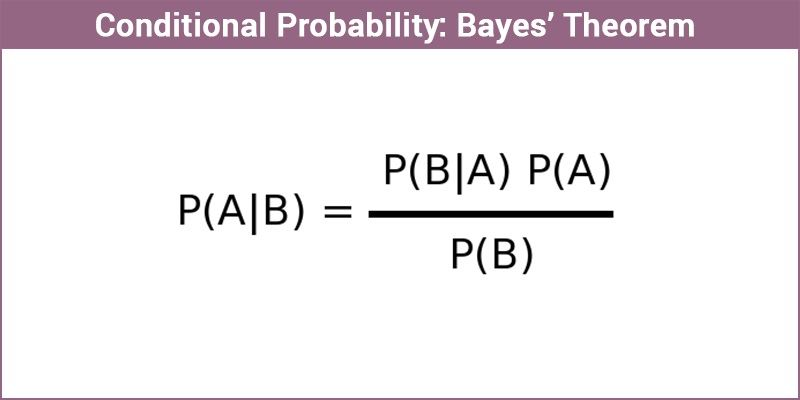

We are trying to compare P(Spam|words in message) with P(Ham|words in message). This means that Spam/Ham corresponds to A in the formula above.

Thus, we need to calculate the prior probabilities, P(Spam), and P(Ham). That is, we need to calculate the proportion of Spam/Ham messages in our training set.

We also need to calculate P(words in message|Spam) and P(words in message|Ham). That is, we need to calculate the probability of particular words showing up in a message given that it is Spam/Ham. Naive Bayes assumes conditional indepedencene, so we will not consider whether the occurrence of a particular word increases the probability of other words occurring.

Since we are comparing two conditional probabilities where the probability of evidence, i.e. P(B), is the same, we can ignore the denominator of Bayes' Theorem.

We will also use a technique called additive smoothing, adding a constant in our calculation of likelihoods, i.e., P(B|A).

In [16]:
# splits training set into spam and ham
spam_training = training_up[training_up['Label'] == 'spam']
ham_training = training_up[training_up['Label'] == 'ham']

# P(Spam) and P(Ham) within training set
p_spam = spam_training.shape[0]/training.shape[0]
p_ham = ham_training.shape[0]/training.shape[0]

In [17]:
# N_Spam (number of words in all spam messages)
n_spam = spam_training['SMS'].apply(len).sum()
print(n_spam)

15190


In [18]:
# N_Ham (number of words in all ham messages)
n_ham = ham_training['SMS'].apply(len).sum()
print(n_ham)

57237


In [19]:
# N_Vocabulary (number of unique words in all messages)
n_vocabulary = len(vocabulary)
print(n_vocabulary)

7783


In [20]:
# constant for additive smoothing
alpha = 1

In [21]:
# initiate parameters
param_spam = {unique_word: 0 for unique_word in vocabulary}
param_ham = {unique_word: 0 for unique_word in vocabulary}

In [22]:
# calculating P(w|Spam) for each word in vocabulary
for word in vocabulary:
    n_words_spam = (spam_training[word].sum())
    param_spam[word] = (n_words_spam + alpha) / (n_spam + alpha*n_vocabulary)
# calculating P(w|Ham) for each word in vocabulary
for word in vocabulary:
    n_words_ham = (ham_training[word].sum())
    param_ham[word] = (n_words_ham + alpha) / (n_ham + alpha*n_vocabulary)

Now we are in a position to implement our algorithm and apply it to our test set.

In [23]:
# classification algorithm using parameters calculated above
def classify(message):
    
    # cleans message, transforming to list without non-digit/letter characters
    message = message.replace('\W', ' ')
    message = message.lower()
    message = message.split()
    
    # calculates P(Spam|Message)
    p_message_given_spam = 1
    for word in message:
        if word in param_spam:
            p_message_given_spam *= param_spam[word]
    p_spam_given_message = p_spam * p_message_given_spam
    
    # calculates P(Ham|Message)
    p_message_given_ham = 1
    for word in message:
        if word in param_ham:
            p_message_given_ham *= param_ham[word]
    p_ham_given_message = p_ham * p_message_given_ham
    
    # compares the two
    if (p_spam_given_message > p_ham_given_message):
        return 'spam'
    elif (p_spam_given_message < p_ham_given_message):
        return 'ham'
    else:
        return 'needs human classification'

In [24]:
# applies algorithm to our test set
test['predicted'] = test['SMS'].apply(classify)
test.head()

,Label,SMS,predicted
0,ham,Later i guess. I needa do mcat study too.,ham
1,ham,But i haf enuff space got like 4 mb...,ham
2,spam,Had your mobile 10 mths? Update to latest Oran...,spam
3,ham,All sounds good. Fingers . Makes it difficult ...,ham
4,ham,"All done, all handed in. Don't know if mega sh...",ham


In [25]:
# measures accuracy
correct = 0
total = len(test['SMS'])
for index, row in test.iterrows():
    if row['Label'] == row['predicted']:
        correct+=1
accuracy = correct/total
print('Correct: {}'.format(correct))
print('Incorrect: {}'.format(total-correct))
print('Accuracy: {:.2f}%'.format(accuracy*100))

Correct: 1095
Incorrect: 19
Accuracy: 98.29%


- Our spam filter is over 98% accurate!
- Later on, we will look at the 19 incorrectly classified messages and try to identify any patterns.